Given a set of images and list of spurious words, remove patches from each image that correspond to a spurious word

In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw, save_image
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import skimage.io as skio
import torch
import clip

In [23]:
wordf = 'spurious.txt'
datadir = '/home/sonia/wildsOrig/data/waterbirds_v1.0'
outdir = './waterbirds'
if not(os.path.isdir(outdir)):
        os.mkdir(outdir)


In [24]:
THRESH = .6
PATCH_SIZE = 100
spurlen = 10

Pipeline: 
1. CLIP_prefix_caption/notebooks/infer.py
2. labelkeys.py
3. Here

Stuff to consider:
1. How many words to consider in spur
2. Threshold of CLIP confidence at which to block out patch
3. Patch size

## Setup
### Get spurious words

In [25]:
with open(wordf, 'r') as f:
    spur = f.readlines()
spur = [l.strip() for l in spur]
spur = spur[:spurlen]
spur[:5]

['tree', 'branch', 'forest', 'beach', 'rock']

### Get images

In [26]:
img_filename = os.path.join(datadir, '001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg')
img = Image.open(img_filename).convert('RGB')

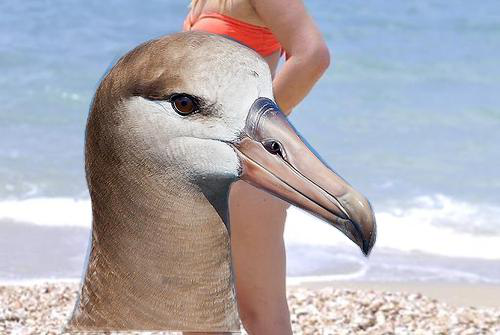

In [27]:
img

In [28]:
# img = io.read_image(img_filename)

In [ ]:
# PATCH_SIZE=100
# patches = img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)

In [ ]:
# patches.size()

torch.Size([3, 3, 5, 100, 100])

In [ ]:
# torch.permute(patches, (1,2,0,3,4)).size()

torch.Size([3, 5, 3, 100, 100])

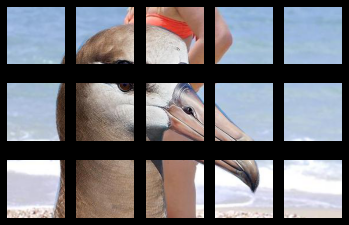

In [ ]:
# fig, ax = plt.subplots(3,5)
# for i in range(3):
#     for j in range(5):
#         sub_img = patches[:, i, j]
#         ax[i][j].imshow(to_pil_image(sub_img))
#         ax[i][j].axis('off')


In [ ]:
DIR = '/home/sonia/wildsOrig/data/waterbirds_v1.0/'
with open(DIR+'metadata.csv','r') as f:
    meta = f.readlines()
meta = meta[1:]
names = [l.split(',')[1] for l in meta]

### Get model

In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

## Predict

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in spur]).to(device)
with torch.no_grad(): 
    text_features = model.encode_text(text_inputs)

In [ ]:
for fname in names:
    img = io.read_image(DIR + fname).to(torch.float)
    img = torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2]))
    kh, kw = PATCH_SIZE, PATCH_SIZE  # kernel size
    dh, dw = PATCH_SIZE, PATCH_SIZE  # stride
    patches = img.unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), 3, -1, kh, kw)

    prepped = []
    for p in range(patches.shape[2]): 
        patch = patches[:,:,p,:,:].squeeze()
        prepped.append(preprocess(to_pil_image(patch)).unsqueeze(0).to(device))
    image_input = torch.cat(prepped).to(torch.uint8)

    with torch.no_grad(): 
        image_features = model.encode_image(image_input)

    # Pick the most similar label for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    sim, ind = similarity.max(dim=1) #for each patch, the strength with and index of the word of its best match
    # print((sim>=THRESH).sum())
    patches[:,:,sim>=THRESH] = torch.zeros(PATCH_SIZE, PATCH_SIZE)

    # Reshape back
    patches_orig = patches.view(unfold_shape)
    output_h = unfold_shape[2] * unfold_shape[4]
    output_w = unfold_shape[3] * unfold_shape[5]
    patches_orig = patches_orig.permute(0, 1, 2, 4, 3, 5).contiguous()
    patches_orig = patches_orig.view(1, 3, output_h, output_w)
    result = to_pil_image(patches_orig.to(torch.uint8).squeeze())

    makepath = os.path.join(outdir, fname.split('/')[0])
    if not(os.path.isdir(makepath)):
        os.mkdir(makepath)
    savepath = os.path.join(outdir, fname)
    result.save(savepath)

In [ ]:
img = io.read_image(DIR + names[0]).to(torch.float)
img = torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2]))
kh, kw = PATCH_SIZE, PATCH_SIZE  # kernel size
dh, dw = PATCH_SIZE, PATCH_SIZE  # stride
patches = img.unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
print(unfold_shape)
patches = patches.contiguous().view(patches.size(0), 3, -1, kh, kw)
print(patches.shape)

torch.Size([1, 3, 3, 5, 100, 100])
torch.Size([1, 3, 15, 100, 100])


In [ ]:
prepped = []
for p in range(patches.shape[2]): 
    patch = patches[:,:,p,:,:].squeeze()
    prepped.append(preprocess(to_pil_image(patch)).unsqueeze(0).to(device))
image_input = torch.cat(prepped).to(torch.uint8)

with torch.no_grad(): 
    image_features = model.encode_image(image_input)

In [ ]:
# Pick the most similar label for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sim, ind = similarity.max(dim=1) #for each patch, the strength with and index of the word of its best match
print((sim>=THRESH).sum())
patches[:,:,sim>=THRESH] = torch.zeros(PATCH_SIZE, PATCH_SIZE)

tensor(14, device='cuda:0')


In [ ]:
# # Reshape back
patches_orig = patches.view(unfold_shape)
output_h = unfold_shape[2] * unfold_shape[4]
output_w = unfold_shape[3] * unfold_shape[5]
patches_orig = patches_orig.permute(0, 1, 2, 4, 3, 5).contiguous()
patches_orig = patches_orig.view(1, 3, output_h, output_w)

# Check for equality
print((patches_orig == img[:, :, :output_h, :output_w]).all())

tensor(False)


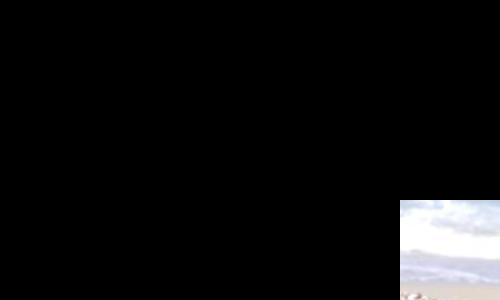

In [ ]:
r=to_pil_image(patches_orig.to(torch.uint8).squeeze())
r

In [ ]:
r=patches_orig.to(torch.uint8).squeeze()
save_image(r.byte(), savepath)

RuntimeError: result type Float can't be cast to the desired output type Byte

In [ ]:
r.byte()

tensor([[[146, 146, 147,  ..., 147, 147, 147],
         [144, 145, 146,  ..., 149, 149, 149],
         [143, 144, 145,  ..., 151, 151, 151],
         ...,
         [255, 255, 245,  ...,   0,   0,   0],
         [255, 251, 237,  ...,   0,   0,   0],
         [236, 226, 215,  ...,   0,   0,   0]],

        [[175, 175, 176,  ..., 179, 179, 179],
         [173, 174, 175,  ..., 181, 181, 181],
         [172, 173, 174,  ..., 183, 183, 183],
         ...,
         [246, 239, 227,  ...,   0,   0,   0],
         [242, 233, 219,  ...,   0,   0,   0],
         [221, 211, 197,  ...,   0,   0,   0]],

        [[215, 215, 216,  ..., 217, 217, 217],
         [213, 214, 215,  ..., 219, 219, 219],
         [212, 213, 214,  ..., 221, 221, 221],
         ...,
         [242, 235, 223,  ...,   0,   0,   0],
         [240, 231, 215,  ...,   0,   0,   0],
         [218, 208, 195,  ...,   0,   0,   0]]], dtype=torch.uint8)

In [ ]:
to_pil_image(r).save(savepath)